In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
root_path = '/content/drive/MyDrive/ColabNotebooks/zindi/Economic Well-Being Prediction Challenge/'

# Starter Notebook: Economic Well-Being Prediction Challenge

Welcome! This starter notebook is designed to get you started on this challenge, where you will be attempting to predict a measure of wealth for different locations across Africa. We will take a look at the data, create a model and then use that to make our first submission. After that we will briefly look at some ways to improve. Let's get started.

# Loading the Data

We're using the pandas library to load the data into dataframes - a tabular data structure that is perfect for this kind of work. Each of the three CSV files from Zindi is loaded into a dataframe and we take a look at the shape of the data (number of rows and columns) as well as a preview of the first 5 rows to get a feel for what we're working with.

In [5]:
import pandas as pd

import xgboost
from xgboost import XGBRegressor


In [6]:
train = pd.read_csv(root_path + 'Train.csv')
print(train.shape)
train.head()

(21454, 19)


,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783
1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898
2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320
3,ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107
4,ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328


In train, we have a set of inputs (like 'urban_or_rural' or 'ghsl_water_surface') and our desired output variable, 'Target'. There are 21454 rows - lots of juicy data!

In [7]:
test = pd.read_csv(root_path + 'Test.csv')
print(test.shape)
test.head()

(7194, 18)


,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline
0,ID_AAcismbB,Democratic Republic of Congo,2007,R,0.000000,0.000000,0.000000,0.000523,0.000131,0.999347,0.660758,0.990942,0.132264,0.069055,0.032627,0.000000,1249.294720,1364.592100
1,ID_AAeBMsji,Democratic Republic of Congo,2007,U,0.000000,0.004239,0.000238,0.001227,0.002860,0.991437,6.441547,5.461365,0.452400,0.000000,0.000000,0.000000,821.019579,1046.028681
2,ID_AAjFMjzy,Uganda,2011,U,0.007359,0.525682,0.132795,0.095416,0.042375,0.196373,587.516458,2.881811,87.387991,3.248483,3.950374,60.070041,3.620455,906.057334
3,ID_AAmMOEEC,Burkina Faso,2010,U,0.000000,0.000089,0.000036,0.001519,0.001358,0.996997,35.141762,33.878927,4.166437,0.000000,0.130727,1.333999,109.493969,775.139189
4,ID_ABguzDxp,Zambia,2007,R,0.000000,0.000138,0.000623,0.000615,0.002961,0.995663,3.442449,33.491994,3.437129,0.133563,0.128997,0.502203,133.643319,835.591501


Test looks just like train but without the 'Target' column and with fewer rows.

In [8]:
ss = pd.read_csv(root_path + 'SampleSubmission.csv')
print(ss.shape)
ss.head()

(7194, 2)


,ID,Target
0,ID_AAcismbB,0
1,ID_AAeBMsji,0
2,ID_AAjFMjzy,0
3,ID_AAmMOEEC,0
4,ID_ABguzDxp,0


The sample submission is just the ID column from test with a 'Target' column where we will put out predictions.

Now that we have the data loaded, we can start exploring.

# EDA

We will explore some trends in the data and look for any anomalies such as missing data. A few examples are done here but you can explore much further yourself and get to know the data better.

First up: let's see how an input like 'nighttime lights' relates to the target column:

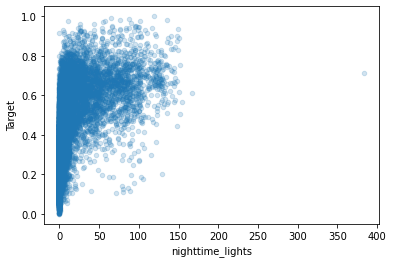

In [ ]:
# Plotting the relationship between an input column and the target
train.plot(x='nighttime_lights', y='Target', kind='scatter', alpha=0.2)

In [ ]:
# Exercise: Try this with different inputs. Any unexpected trends?

As you might have guessed, places that emit more light tend to be wealthier, but there is a lot of variation.

We can also look at categorical columns like 'country' or 'urban_vs_rural' and see the distribution of the target for each group:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


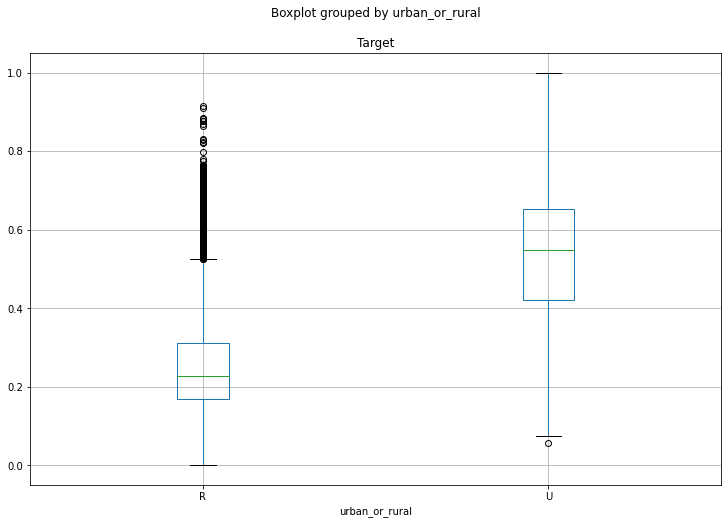

In [ ]:
# Looking at the wealth distribution for urban vs rural
train.boxplot(by='urban_or_rural', column='Target', figsize=(12, 8))

In [ ]:
# Exercise: which is the country with the higest average wealth_index according to this dataset?

Again, not unexpected. Rural areas tend to be less wealthy than urban areas.

Now the scary question: do we have missing data to deal with?

In [ ]:
train.isna().sum() # Hooray - no missing data!

ID                                         0
country                                    0
year                                       0
urban_or_rural                             0
ghsl_water_surface                         0
ghsl_built_pre_1975                        0
ghsl_built_1975_to_1990                    0
ghsl_built_1990_to_2000                    0
ghsl_built_2000_to_2014                    0
ghsl_not_built_up                          0
ghsl_pop_density                           0
landcover_crops_fraction                   0
landcover_urban_fraction                   0
landcover_water_permanent_10km_fraction    0
landcover_water_seasonal_10km_fraction     0
nighttime_lights                           0
dist_to_capital                            0
dist_to_shoreline                          0
Target                                     0
dtype: int64

See what other trends you can uncover - we have only scratched the surface here. 

In [ ]:
# Exercise: explore the data further

# Modelling

We've had a look at our data and it looks good! Let's see if we can create a model to predict the Target given some of our inputs. To start with we will use only the numeric columns, so that we can fit a model right away. 

In [ ]:
in_cols = list(train.columns[4:-1])
print('Input columns:', in_cols)

Input columns: ['ghsl_water_surface', 'ghsl_built_pre_1975', 'ghsl_built_1975_to_1990', 'ghsl_built_1990_to_2000', 'ghsl_built_2000_to_2014', 'ghsl_not_built_up', 'ghsl_pop_density', 'landcover_crops_fraction', 'landcover_urban_fraction', 'landcover_water_permanent_10km_fraction', 'landcover_water_seasonal_10km_fraction', 'nighttime_lights', 'dist_to_capital', 'dist_to_shoreline']


To evaluate our model, we need to keep some data separate. We will split out data into X (inputs) and y (output) and then further split into train and test sets with the following code:

In [ ]:
from sklearn.model_selection import train_test_split

X, y = train[in_cols], train['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58) # Random state keeps the split consistent
print(X_train.shape, X_test.shape)

(17163, 17) (4291, 17)


We now have a nice test set of ~4200 rows. We will train our model and then use this test set to calculate our score.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#model = RandomForestRegressor() # Create the model
model = XGBRegressor()
model.fit(X_train, y_train) # Train it (this syntax looks the same for all sklearn models)
model.score(X_test, y_test) # Show a score

[18:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6721923547231125

What is the score above? The default for regression models is the R^2 score, a measure of how well the mode does at predicting the target. 0.69 is pretty good - let's plot the predictions vs the actual values and see how close it looks to a straight line:

In [ ]:
import lightgbm as lgb

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['mse'],
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

model2 = lgb.LGBMRegressor(**hyper_params)
model2.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mse',
        early_stopping_rounds=1000)

In [ ]:
mean_squared_error(y_test, model2.predict(X_test), squared=False)

0.10209168334378746

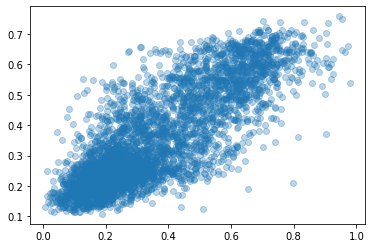

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(y_test, model.predict(X_test), alpha=0.3)

This looks great - most predictions are nice and close to the true value! But we still don't have a way to link this to the leaderboard score on Zindi. Let's remedy that by calculating the Root Mean Squared Error, the same metric Zindi uses. 

In [ ]:
from sklearn.metrics import mean_squared_error

# The `squared=False` bit tells this function to return the ROOT mean squared error
mean_squared_error(y_test, model.predict(X_test), squared=False)

0.11281423916700832

Great stuff. Let's make a submission and then move on to looking for ways to improve.

In [ ]:
# Copying our predictions into the submission dataframe - make sure the rows are in the same order!
ss['Target'] = model2.predict(test[in_cols]) 
ss.head()

,ID,Target
0,ID_AAcismbB,0.135496
1,ID_AAeBMsji,0.210891
2,ID_AAjFMjzy,0.641215
3,ID_AAmMOEEC,0.398188
4,ID_ABguzDxp,0.263102


We now have our predictions in the right format to submit. The following line saves this to a file that you can then upload to get a score:

In [ ]:
ss.to_csv(root_path + 'first_submission.csv', index=False)

# Getting Better

You might have noticed that your score on Zindi wasn't as good as the one you got above. This is because the test set comes from different countries to the train set. When we did a random split, we ended up with our local train and test both coming from the same countries - and it's easier for a model to extrapolate within countries than it is for it to make predictions for a new location. 

So our first step might be to make a scoring function that splits the data according to country, and measures the model performance on unseen countries. Try it and share your testing methods in the discussions. And look at the following questions:
- Does your score drop when you score your model on countries it wasn't trained with?
- Does the new score more accurately match the leaderboard score?
- Are any countries particularly 'hard' to make predictions in?

In [ ]:
# You code for a enw model evaluation method here

Knowing how well our model is doing is useful, but however you measure that we also need ways to improve this performance! There are a few ways to do this:

- Feed the model better data. How? Feature engineering! If we can add meaningful features the model will have more data to work with.
- Tune your models. We used the default parameters - perhaps we can tweak some hyperparameters to make our models better
- Try fancier models. Perhaps XGBoost or a neural network is better than Random Forest at this task

Let's do a little of each. First up, let's create a numeric feature that encodes the 'urban_or_rural' column as something the model can use:

In [ ]:
# Turning a categorical column into a numeric feature
train['is_urban'] = (train['urban_or_rural'] == 'U').astype(int)
test['is_urban'] = (test['urban_or_rural'] == 'U').astype(int)
train.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target,is_urban
0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783,0
1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898,0
2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320,0
3,ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107,0
4,ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328,1



Note that whenever we add features to train, *we also need to add them to test* otherwise we won't be able to make our predictions.

With this extra feature, we can fit a new model:

In [ ]:
in_cols.append('is_urban') # Adding the new features to our list of input columns

# Replace this with your chosen method for evaluating a model:
X, y = train[in_cols], train['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58)
model = RandomForestRegressor()
model.fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test), squared=False)

0.10422828805215191

Did your score improve?

Next, let's tune our model by adjusting the maximum depth. This is one of many hyperparameters that can be tweaked on a Random Forest model. Here I just try a few randomly chosen values, but you could also use a grid search to try values more methodically.

In [ ]:
for max_depth in [3, 5, 8, 10, 14, 18]:
    model = RandomForestRegressor()
    # Again, you van use a better method to evaluate the model here...
    model.fit(X_train, y_train)
    print(max_depth, mean_squared_error(y_test, model.predict(X_test), squared=False))

3 0.10408738649987018
5 0.10460409487822683
8 0.10431593287991386
10 0.10471826576013885
14 0.10443815776937627
18 0.10429272601442548


In this case, it looks like we can improve our performance by specifying a max_depth to limit model complexity.

Finally, let's try a different model out of curiosity:

In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
# Exercise: fit and score the model. Does it beat your other scores? Can you use it to make a submission?
model.fit(X_train, y_train)
print(max_depth, mean_squared_error(y_test, model.predict(X_test), squared=False))

CatBoostError: ignored

Remember, you can ask questions and share ideas in the discussions. 

### GOOD LUCK!

In [10]:
train.set_index("close").Weighted_Price.plot(figsize=(14,7), title="Bitcoin Weighted Price")

KeyError: ignored